## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix, hstack, vstack

from tqdm import tqdm

from sklearn.metrics import accuracy_score, classification_report, log_loss, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix, confusion_matrix, make_scorer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb


RANDOM_STATE = 0

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_samp = pd.read_csv("sample_solution.csv")

## Рассмотрим датасет поближе

In [3]:
df_train.head(3)

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,6145,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.7,3922,408,Айгуль Ляпина,5.0,Рекомендую книгу в прочтению/прослушиванию. Ес...,0,3,0,0,0,0,0
1,7006,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Olga T,5.0,"Удивительно, что сейчас возникает ТАКАЯ литера...",0,1,0,0,0,0,1
2,1124,Дети мои,Гузель Яхина,https://www.litres.ru/guzel-yahina/deti-moi/,4.4,8032,702,Кирилл Чириков,5.0,"Душевно, жизненно, чувственно, проникновенно!!...",0,0,0,1,0,0,1


## Добавим новых признаков

In [4]:
# соединим train и test
df_all = pd.concat([df_train, df_test])

In [5]:
dct_likes = df_train.groupby(['Название книги'])['Лайки на отзыв'].sum().to_dict()
dct_dislikes = df_train.groupby(['Название книги'])['Дислайки на отзыв'].sum().to_dict()

In [6]:
df_all['likes'] = df_all['Название книги'].map(dct_likes)
df_all['dislikes'] = df_all['Название книги'].map(dct_dislikes)
df_all['rate_likes'] = df_all['likes'] / (df_all['likes'] + df_all['dislikes'])

In [7]:
count_author = df_train.groupby(['Автор'])['Название книги'].count().to_dict()
nunique_author = df_train.groupby(['Автор'])['Название книги'].nunique().to_dict()
df_all['count_author'] = df_all['Автор'].map(count_author)
df_all['nunique_author'] = df_all['Автор'].map(nunique_author)
df_all['rate_unique_author'] = df_all['nunique_author'] / df_all['count_author']

In [8]:
# удаление пунктуации, чисел и др.
pattern = r'[а-яa-z]+'
prep = df_all['Отзыв'].str.lower().str.findall(pattern).str.join(' ')

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [10]:
russian_stopwords = stopwords.words("russian")

In [11]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [12]:
# Лемматизация
lemm_texts_column = []
for text in tqdm(prep):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
lemm_texts_column[0]

100%|██████████| 6914/6914 [02:03<00:00, 56.18it/s]


'рекомендовать книга прочтение прослушивание задуматься написать осень всплакнуть хотеться рада жить время'

In [13]:
one_hot_labels = ['Название книги', 'Автор', 'Ссылка на литрес']

In [14]:
df_all['Имя читателя'] = df_all['Имя читателя'].rank()

In [15]:
df_all = pd.get_dummies(df_all, columns=one_hot_labels)

In [16]:
df_all["len_reviews"] = df_all["Отзыв"].map(len)
df_all["len_reviews_lemmed"] = pd.Series(lemm_texts_column).map(len)

In [17]:
%%time
tfidf_chars = CountVectorizer(analyzer='char', max_features=30000, ngram_range=(3, 7), min_df=5, max_df=0.8)
tfidf_words = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.8)
csr_chars = tfidf_chars.fit_transform(df_all['Отзыв'])
csr_words = tfidf_words.fit_transform(df_all['Отзыв'])
tfidf_chars_lem = CountVectorizer(analyzer='char', max_features=30000, ngram_range=(3, 7), min_df=5, max_df=0.8)
tfidf_words_lem = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.8)
csr_chars_lemmed = tfidf_chars_lem.fit_transform(lemm_texts_column)
csr_words_lemmed = tfidf_words_lem.fit_transform(lemm_texts_column)

Wall time: 55.2 s


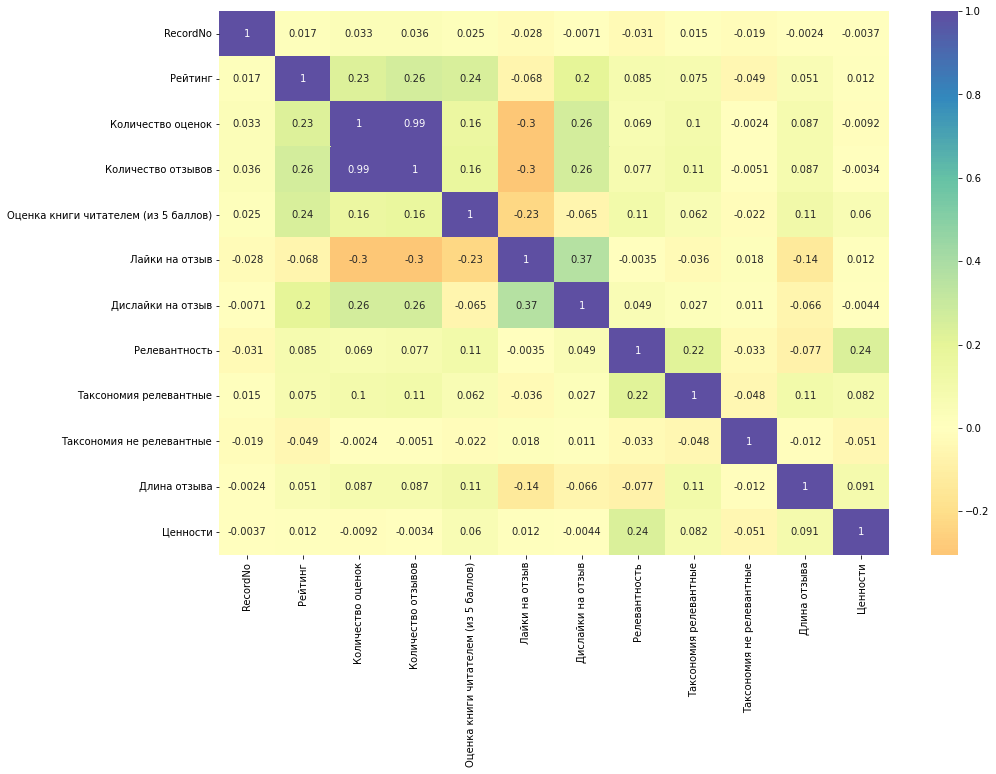

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(df_train.corr(method='spearman'), annot=True, center=0, cmap='Spectral');

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RecordNo                              4839 non-null   int64  
 1   Название книги                        4839 non-null   object 
 2   Автор                                 4839 non-null   object 
 3   Ссылка на литрес                      4839 non-null   object 
 4   Рейтинг                               4839 non-null   float64
 5   Количество оценок                     4839 non-null   int64  
 6   Количество отзывов                    4839 non-null   int64  
 7   Имя читателя                          4839 non-null   object 
 8   Оценка книги читателем (из 5 баллов)  4070 non-null   float64
 9   Отзыв                                 4839 non-null   object 
 10  Лайки на отзыв                        4839 non-null   int64  
 11  Дислайки на отзыв

In [20]:
df_all = df_all.fillna(0)

## Построим на распределение данных

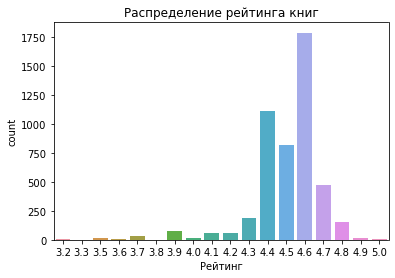

In [21]:
_ = sns.countplot(x = "Рейтинг" , data  = df_train).set_title('Распределение рейтинга книг')

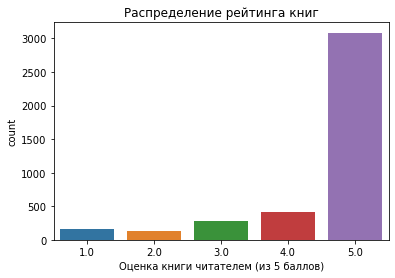

In [22]:
_ = sns.countplot(x = 'Оценка книги читателем (из 5 баллов)', data  = df_train).set_title('Распределение рейтинга книг')

Взглянем на несколько величин сразу

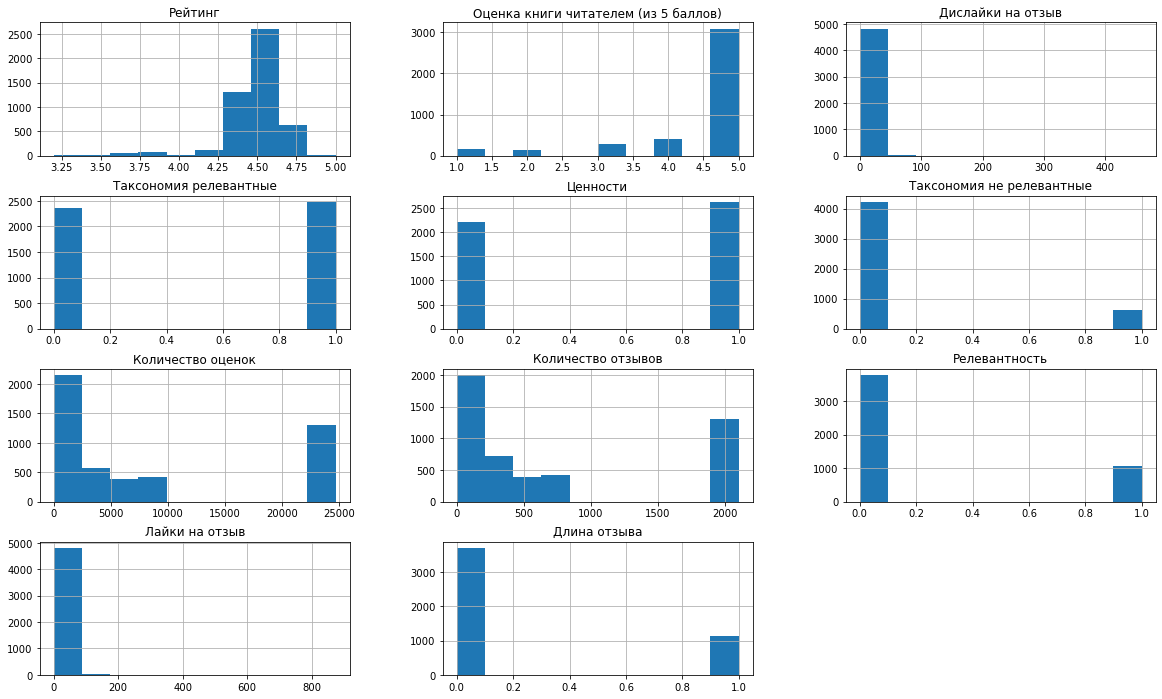

In [23]:
features = list(set(df_train.columns.values) - set(['RecordNo']))

_ = df_train[features].hist(figsize=(20,12))

## Выделим выборки

In [24]:
mass_label = ['Релевантность',
               'Таксономия релевантные', 'Таксономия не релевантные',
               'Длина отзыва', 'Ценности']

In [25]:
object_label = df_all.dtypes[df_all.dtypes == "object"].index.values

In [26]:
object_label = np.append(object_label,"RecordNo")

In [27]:
csr_all = hstack([csr_matrix(df_all.drop(mass_label+list(object_label), axis=1)), csr_words, csr_chars])

X = csr_all[:df_train.shape[0]]

y = df_train[mass_label]

test = csr_all[df_train.shape[0]:]

feats = list(df_all.drop(mass_label+list(object_label), axis=1).columns)\
                + sorted(list(tfidf_chars.vocabulary_)) + sorted(list(tfidf_words.vocabulary_))

In [28]:
# разделение выборок с лемматизацией
csr_all_lem = hstack([csr_matrix(df_all.drop(mass_label+list(object_label), axis=1)), 
                      csr_chars_lemmed, csr_words_lemmed])

X_lem = csr_all_lem[:df_train.shape[0]]

y_lem = df_train[mass_label]

test_lem = csr_all_lem[df_train.shape[0]:]

feats_lem = list(df_all.drop(mass_label+list(object_label), axis=1).columns)\
                + sorted(list(tfidf_chars_lem.vocabulary_)) + sorted(list(tfidf_words_lem.vocabulary_))

In [29]:
X

<4839x41908 sparse matrix of type '<class 'numpy.float64'>'
	with 4430547 stored elements in Compressed Sparse Row format>

In [30]:
X_lem

<4839x38969 sparse matrix of type '<class 'numpy.float64'>'
	with 4162702 stored elements in Compressed Sparse Row format>

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y, test_size=0.3, random_state=42)

In [32]:
y_train.sum()

Релевантность                 756
Таксономия релевантные       1723
Таксономия не релевантные     432
Длина отзыва                  799
Ценности                     1847
dtype: int64

In [33]:
y_train.count()-y_train.sum()

Релевантность                2631
Таксономия релевантные       1664
Таксономия не релевантные    2955
Длина отзыва                 2588
Ценности                     1540
dtype: int64

In [34]:
y_train.sum()/y_train.count()

Релевантность                0.223206
Таксономия релевантные       0.508710
Таксономия не релевантные    0.127547
Длина отзыва                 0.235902
Ценности                     0.545320
dtype: float64

## Обучение модели и оценка точности

In [35]:
# балансировка классов (из наибольшего класса отбрасывается разница превышения над наименьшим по количеству)
def balance_train(X, y):
    y_ = y.reset_index(drop=True)
    y_counts = y_.value_counts()
    print(f'y\n{y_counts}')        
    size_min = min(y_counts)
    y_min = y_[y_==y_counts[y_counts==size_min].index[0]]
    y_max = y_[y_==y_counts[y_counts==max(y_counts)].index[0]].sample(size_min, random_state=RANDOM_STATE)
    y_ = pd.concat([y_max, y_min])
    idx = y_.index
    X_ = X[idx, :]
    print(f'\nAfter resample\n{y_.value_counts()}')
    return X_, y_

# обучение модели
def fit_func(clf, X, y, X_test=[], y_test=[], is_test=True):
    label = y.name          
    X_bal, y_bal = balance_train(X, y)
    print(X_bal.shape[1])
    if is_test and clf.__class__.__name__ in ['XGBClassifier', 'LGBMClassifier']:
        fit_clf = clf.fit(X_bal, y_bal, eval_set=[(X_test, y_test)])
    else:
        fit_clf = clf.fit(X_bal, y_bal)
    return fit_clf

# получение прогнозов
def pred_func(fit_clf, test, label):
    test_ = test.copy() 
    pred = (fit_clf, fit_clf.predict(test_))    
    return pred

# получение вероятностей прогнозов
def pred_proba_func(fit_clf, test, label):
    test_ = test.copy() 
    pred_proba = (fit_clf, fit_clf.predict_proba(test_)[:, 1])    
    return pred_proba

# расчет метрики
def recall_func(preds, y_test, mass_label=mass_label):
    recalls = []
    for i in range(len(mass_label)):
        recalls.append((f"Recall {preds[i][0]} {mass_label[i]}:", 
                        recall_score(y_test[mass_label[i]], preds[i][1], average='macro')))
    return recalls

# custom recall для xgboost
def custom_recall(y_true, y_pred):
    return -recall_score(y_true, np.round(y_pred), average='macro', zero_division=True)

In [36]:
# отображение результатов обучения моделей
def view_test(y_test, pred, feats):
    label = y_test.name
    result = 0 
    clf = pred[0]
    clf_name = clf.__class__.__name__
    if clf_name == 'Pipeline':
        print(pred[0])
    else:
        print(clf_name)
    recall_ = recall_score(y_test, pred[1], average='macro', zero_division=True)
    print(f'recall {y_test.name}', recall_)
    labels_train = np.unique(y_test)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), )
    for j in range(2):
        is_abs = ['', 'abs'][j]
        axes[j].set_title(f'{y_test.name}, {is_abs}\nrec: {np.round(recall_, 3)}')
        cm = confusion_matrix(y_test, pred[1], labels=labels_train, normalize=['true', None][j])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_train)
        disp.plot(ax=axes[j]);
        
    print()
    print(f'Feature_importances {label}:')
    print(np.round(pd.Series(clf.feature_importances_, feats).sort_values(ascending=False), 3)[:20])

### test Таксономия релевантные

In [37]:
%%time
clf_takson_relev = lgb.LGBMClassifier(random_state=RANDOM_STATE)

clf_takson_relev_fit = fit_func(clf_takson_relev, X_train_lem, y_train_lem['Таксономия релевантные'],
                                X_test_lem, y_test_lem['Таксономия релевантные'])

y
1    1723
0    1664
Name: Таксономия релевантные, dtype: int64

After resample
1    1664
0    1664
Name: Таксономия релевантные, dtype: int64
38969
[1]	valid_0's binary_logloss: 0.604487
[2]	valid_0's binary_logloss: 0.531702
[3]	valid_0's binary_logloss: 0.471386
[4]	valid_0's binary_logloss: 0.420518
[5]	valid_0's binary_logloss: 0.376264
[6]	valid_0's binary_logloss: 0.33834
[7]	valid_0's binary_logloss: 0.305421
[8]	valid_0's binary_logloss: 0.276396
[9]	valid_0's binary_logloss: 0.251381
[10]	valid_0's binary_logloss: 0.228551
[11]	valid_0's binary_logloss: 0.208652
[12]	valid_0's binary_logloss: 0.190649
[13]	valid_0's binary_logloss: 0.174961
[14]	valid_0's binary_logloss: 0.159862
[15]	valid_0's binary_logloss: 0.14665
[16]	valid_0's binary_logloss: 0.134787
[17]	valid_0's binary_logloss: 0.124057
[18]	valid_0's binary_logloss: 0.114651
[19]	valid_0's binary_logloss: 0.105776
[20]	valid_0's binary_logloss: 0.0977696
[21]	valid_0's binary_logloss: 0.0914112
[22]	valid_0's bina

In [38]:
pred_proba_train_takson_relev = pred_proba_func(clf_takson_relev_fit, X_train_lem, label='Таксономия релевантные')
pred_proba_takson_relev = pred_proba_func(clf_takson_relev_fit, X_test_lem, label='Таксономия релевантные')

pred_takson_relev = pred_func(clf_takson_relev_fit, X_test_lem, label='Таксономия релевантные')

LGBMClassifier
recall Таксономия релевантные 0.9885855683269477

Feature_importances Таксономия релевантные:
герой                 95
история               86
 сила                 85
дьб                   82
боль                  80
дух                   76
 детст                68
 эмоция               65
len_reviews           64
 воспо                62
 доля                 60
испытан               55
 право                55
len_reviews_lemmed    50
несправедливость      40
лод                   38
азани                 38
деду                  33
Имя читателя          33
 эмо                  32
dtype: int32


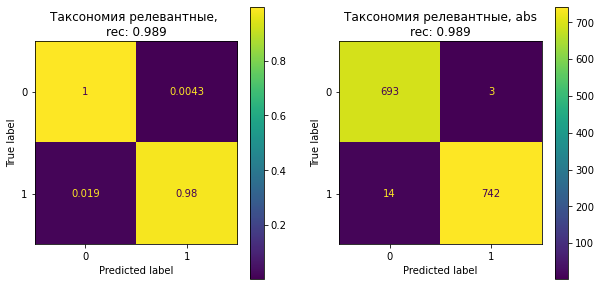

In [39]:
recall_takson_relev = recall_score(y_test['Таксономия релевантные'], 
                                   pred_takson_relev[1], average='macro', zero_division=True)
view_test(y_test['Таксономия релевантные'], pred_takson_relev, feats_lem)

### test Таксономия не релевантные

In [40]:
X_train_stack_takson_rel = hstack([X_train_lem, 
                                    csr_matrix(pred_proba_train_takson_relev[1].reshape(-1, 1))])

X_test_stack_takson_rel = hstack([X_test_lem, 
                                  csr_matrix(pred_proba_takson_relev[1].reshape(-1, 1))])

In [41]:
%%time
clf_takson_not_relev = xgb.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.03,
                                         subsample=0.8, colsample_bytree=0.8, colsample_bynode=0.7, 
                                         eval_metric=custom_recall,
                                         random_state=RANDOM_STATE)

clf_takson_not_relev_fit = fit_func(clf_takson_not_relev, 
                                    X_train_stack_takson_rel, y_train['Таксономия не релевантные'],
                                    X_test_stack_takson_rel, y_test['Таксономия не релевантные'])

y
0    2955
1     432
Name: Таксономия не релевантные, dtype: int64

After resample
0    432
1    432
Name: Таксономия не релевантные, dtype: int64
38970
[0]	validation_0-logloss:0.67201	validation_0-custom_recall:-0.90736
[1]	validation_0-logloss:0.65330	validation_0-custom_recall:-0.90694
[2]	validation_0-logloss:0.63450	validation_0-custom_recall:-0.92071
[3]	validation_0-logloss:0.61692	validation_0-custom_recall:-0.91991
[4]	validation_0-logloss:0.60093	validation_0-custom_recall:-0.91168
[5]	validation_0-logloss:0.58466	validation_0-custom_recall:-0.92423
[6]	validation_0-logloss:0.56893	validation_0-custom_recall:-0.91836
[7]	validation_0-logloss:0.55360	validation_0-custom_recall:-0.91325
[8]	validation_0-logloss:0.54041	validation_0-custom_recall:-0.91797
[9]	validation_0-logloss:0.52720	validation_0-custom_recall:-0.91639
[10]	validation_0-logloss:0.51478	validation_0-custom_recall:-0.91561
[11]	validation_0-logloss:0.50256	validation_0-custom_recall:-0.92895
[12]	validation_

[115]	validation_0-logloss:0.14426	validation_0-custom_recall:-0.95642
[116]	validation_0-logloss:0.14335	validation_0-custom_recall:-0.95642
[117]	validation_0-logloss:0.14232	validation_0-custom_recall:-0.95681
[118]	validation_0-logloss:0.14212	validation_0-custom_recall:-0.95642
[119]	validation_0-logloss:0.14160	validation_0-custom_recall:-0.95642
[120]	validation_0-logloss:0.14105	validation_0-custom_recall:-0.95642
[121]	validation_0-logloss:0.14046	validation_0-custom_recall:-0.95603
[122]	validation_0-logloss:0.13958	validation_0-custom_recall:-0.95642
[123]	validation_0-logloss:0.13933	validation_0-custom_recall:-0.95917
[124]	validation_0-logloss:0.13848	validation_0-custom_recall:-0.95917
[125]	validation_0-logloss:0.13772	validation_0-custom_recall:-0.95917
[126]	validation_0-logloss:0.13736	validation_0-custom_recall:-0.95917
[127]	validation_0-logloss:0.13656	validation_0-custom_recall:-0.95917
[128]	validation_0-logloss:0.13581	validation_0-custom_recall:-0.95917
[129]	

[231]	validation_0-logloss:0.10250	validation_0-custom_recall:-0.96583
[232]	validation_0-logloss:0.10270	validation_0-custom_recall:-0.96583
[233]	validation_0-logloss:0.10229	validation_0-custom_recall:-0.96583
[234]	validation_0-logloss:0.10206	validation_0-custom_recall:-0.96583
[235]	validation_0-logloss:0.10205	validation_0-custom_recall:-0.96583
[236]	validation_0-logloss:0.10175	validation_0-custom_recall:-0.96623
[237]	validation_0-logloss:0.10150	validation_0-custom_recall:-0.96583
[238]	validation_0-logloss:0.10152	validation_0-custom_recall:-0.96583
[239]	validation_0-logloss:0.10143	validation_0-custom_recall:-0.96583
[240]	validation_0-logloss:0.10118	validation_0-custom_recall:-0.96583
[241]	validation_0-logloss:0.10109	validation_0-custom_recall:-0.96583
[242]	validation_0-logloss:0.10085	validation_0-custom_recall:-0.96583
[243]	validation_0-logloss:0.10042	validation_0-custom_recall:-0.96583
[244]	validation_0-logloss:0.10012	validation_0-custom_recall:-0.96583
[245]	

In [42]:
pred_proba_train_takson_not_relev = pred_proba_func(clf_takson_not_relev_fit, 
                                  X_train_stack_takson_rel, 
                                  label='Таксономия не релевантные')

pred_proba_takson_not_relev = pred_proba_func(clf_takson_not_relev_fit, 
                                  X_test_stack_takson_rel, 
                                  label='Таксономия не релевантные')


pred_takson_not_relev = pred_func(clf_takson_not_relev_fit, 
                                  X_test_stack_takson_rel, 
                                  label='Таксономия не релевантные')

XGBClassifier
recall Таксономия не релевантные 0.9650471575668427

Feature_importances Таксономия не релевантные:
 филь      0.024
родо       0.019
ждать      0.019
одолже     0.018
иковы      0.017
 фил       0.016
филь       0.015
овый       0.014
долже      0.013
овый       0.012
ковы       0.011
фильм      0.011
фил        0.010
 продол    0.010
ерпен      0.009
етерп      0.009
етер       0.009
льм        0.008
ый б       0.008
овы        0.008
dtype: float32


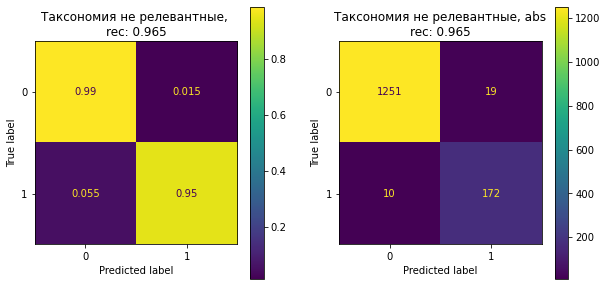

In [43]:
recall_takson_not_relev = recall_score(y_test['Таксономия не релевантные'], 
                                   pred_takson_not_relev[1], average='macro', zero_division=True)
view_test(y_test['Таксономия не релевантные'], pred_takson_not_relev, feats_lem+['Таксономия релевантные'])

### test Ценности

In [44]:
X_train_stack_takson_not_rel = hstack([X_train_lem, 
                                       csr_matrix(np.round(pred_proba_train_takson_relev[1]).reshape(-1, 1)),
                                       csr_matrix(np.round(pred_proba_train_takson_not_relev[1]).reshape(-1, 1))])
X_test_stack_takson_not_rel = hstack([X_test_lem, 
                                      csr_matrix(np.round(pred_proba_takson_relev[1]).reshape(-1, 1)),
                                      csr_matrix(np.round(pred_proba_takson_not_relev[1]).reshape(-1, 1))])

In [45]:
%%time
clf_cen = lgb.LGBMClassifier(random_state=RANDOM_STATE)

clf_cen_fit = fit_func(clf_cen, X_train_stack_takson_not_rel, y_train['Ценности'], 
                       X_test_stack_takson_not_rel, y_test['Ценности'])

y
1    1847
0    1540
Name: Ценности, dtype: int64

After resample
1    1540
0    1540
Name: Ценности, dtype: int64
38971
[1]	valid_0's binary_logloss: 0.622124
[2]	valid_0's binary_logloss: 0.563601
[3]	valid_0's binary_logloss: 0.515369
[4]	valid_0's binary_logloss: 0.474887
[5]	valid_0's binary_logloss: 0.439259
[6]	valid_0's binary_logloss: 0.408959
[7]	valid_0's binary_logloss: 0.383522
[8]	valid_0's binary_logloss: 0.360534
[9]	valid_0's binary_logloss: 0.342878
[10]	valid_0's binary_logloss: 0.324559
[11]	valid_0's binary_logloss: 0.308402
[12]	valid_0's binary_logloss: 0.294773
[13]	valid_0's binary_logloss: 0.282052
[14]	valid_0's binary_logloss: 0.271979
[15]	valid_0's binary_logloss: 0.260854
[16]	valid_0's binary_logloss: 0.253008
[17]	valid_0's binary_logloss: 0.244016
[18]	valid_0's binary_logloss: 0.237274
[19]	valid_0's binary_logloss: 0.229962
[20]	valid_0's binary_logloss: 0.222806
[21]	valid_0's binary_logloss: 0.2164
[22]	valid_0's binary_logloss: 0.211498
[23]	vali

In [46]:
pred_proba_train_cen = pred_proba_func(clf_cen_fit, X_train_stack_takson_not_rel, label='Ценности')
pred_proba_cen = pred_proba_func(clf_cen_fit, X_test_stack_takson_not_rel, label='Ценности')

pred_cen = pred_func(clf_cen_fit, X_test_stack_takson_not_rel, label='Ценности')

LGBMClassifier
recall Ценности 0.9471191972183248

Feature_importances Ценности:
жизнь         69
день          61
мир           61
 любовь       56
труд          51
дело          50
 семья        49
 правда       44
душевны       44
 уваже        43
работа        37
 вниман       36
 сила         35
пряжени       32
влас          31
цель          31
оинс          28
внутренний    28
весть         26
ернос         25
dtype: int32


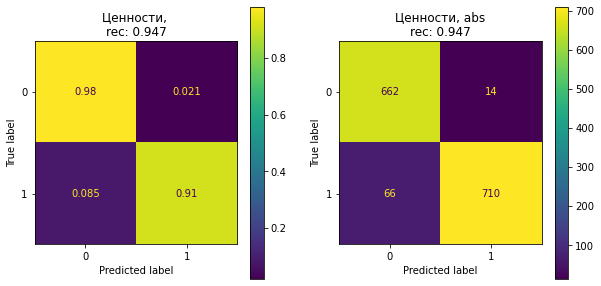

In [47]:
recall_cen = recall_score(y_test['Ценности'], 
                                   pred_cen[1], average='macro', zero_division=True)
view_test(y_test['Ценности'], pred_cen, feats_lem+['Таксономия релевантные']+['Таксономия не релевантные'])

### test Длина отзыва

In [48]:
X_train_stack_cen = hstack([X_train, 
                          csr_matrix(np.round(pred_proba_train_takson_relev[1].reshape(-1, 1))),
                           csr_matrix(np.round(pred_proba_train_takson_not_relev[1].reshape(-1, 1))),
                           csr_matrix(np.round(pred_proba_train_cen[1].reshape(-1, 1)))
                           ])
X_test_stack_cen = hstack([X_test, 
                           csr_matrix(pred_takson_relev[1].reshape(-1, 1)),
                           csr_matrix(pred_takson_not_relev[1].reshape(-1, 1)),
                           csr_matrix(pred_cen[1].reshape(-1, 1)),
                            ])

In [49]:
%%time
clf_len = lgb.LGBMClassifier(random_state=RANDOM_STATE) 

clf_len_fit = fit_func(clf_len, X_train_stack_cen, y_train['Длина отзыва'], 
                       X_test_stack_cen, y_test['Длина отзыва'])

y
0    2588
1     799
Name: Длина отзыва, dtype: int64

After resample
0    799
1    799
Name: Длина отзыва, dtype: int64
41911
[1]	valid_0's binary_logloss: 0.653351
[2]	valid_0's binary_logloss: 0.62044
[3]	valid_0's binary_logloss: 0.593544
[4]	valid_0's binary_logloss: 0.573121
[5]	valid_0's binary_logloss: 0.553348
[6]	valid_0's binary_logloss: 0.535342
[7]	valid_0's binary_logloss: 0.522779
[8]	valid_0's binary_logloss: 0.507557
[9]	valid_0's binary_logloss: 0.493878
[10]	valid_0's binary_logloss: 0.485906
[11]	valid_0's binary_logloss: 0.477083
[12]	valid_0's binary_logloss: 0.468668
[13]	valid_0's binary_logloss: 0.461223
[14]	valid_0's binary_logloss: 0.454421
[15]	valid_0's binary_logloss: 0.448804
[16]	valid_0's binary_logloss: 0.445933
[17]	valid_0's binary_logloss: 0.441316
[18]	valid_0's binary_logloss: 0.439857
[19]	valid_0's binary_logloss: 0.435934
[20]	valid_0's binary_logloss: 0.432484
[21]	valid_0's binary_logloss: 0.428646
[22]	valid_0's binary_logloss: 0.424091
[2

In [50]:
pred_proba_train_len = pred_proba_func(clf_len_fit, X_train_stack_cen, label='Длина отзыва')
pred_proba_len = pred_proba_func(clf_len_fit, X_test_stack_cen, label='Длина отзыва')

pred_len = pred_func(clf_len_fit, X_test_stack_cen, label='Длина отзыва')

LGBMClassifier
recall Длина отзыва 0.8402043884978243

Feature_importances Длина отзыва:
len_reviews                  94
Имя читателя                 62
len_reviews_lemmed           51
Таксономия релевантные       44
Длина отзыва                 43
наб                          42
лишь                         40
фактам                       35
Таксономия не релевантные    35
вспоминала                   34
метит                        34
м, ко                        32
Лайки на отзыв               31
мам                          30
после                        23
м в                          23
мет                          22
суро                         21
Дислайки на отзыв            21
м про                        21
dtype: int32


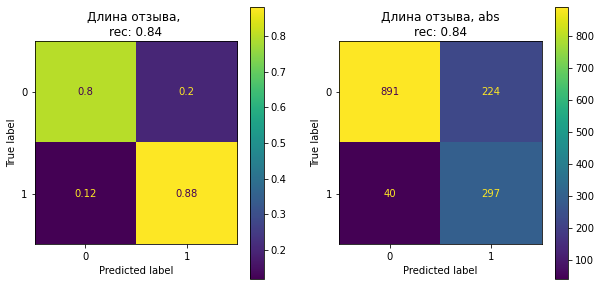

In [51]:
recall_len = recall_score(y_test['Длина отзыва'], pred_len[1], average='macro', zero_division=True)
view_test(y_test['Длина отзыва'], pred_len, 
          feats+['Таксономия релевантные', 'Таксономия не релевантные', 'Длина отзыва'])

### test Релевантность

In [52]:
%%time
clf_rel = xgb.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.03, 
                            subsample=0.8, colsample_bytree=0.8, colsample_bynode=0.3, 
                            eval_metric=custom_recall,
                            random_state=RANDOM_STATE)

clf_rel_fit = fit_func(clf_rel, X_train, y_train['Релевантность'], 
                       X_test, y_test['Релевантность'])

y
0    2631
1     756
Name: Релевантность, dtype: int64

After resample
0    756
1    756
Name: Релевантность, dtype: int64
41908
[0]	validation_0-logloss:0.68694	validation_0-custom_recall:-0.65332
[1]	validation_0-logloss:0.68180	validation_0-custom_recall:-0.70153
[2]	validation_0-logloss:0.67752	validation_0-custom_recall:-0.68576
[3]	validation_0-logloss:0.67306	validation_0-custom_recall:-0.69474
[4]	validation_0-logloss:0.66813	validation_0-custom_recall:-0.70292
[5]	validation_0-logloss:0.66403	validation_0-custom_recall:-0.70691
[6]	validation_0-logloss:0.65939	validation_0-custom_recall:-0.71161
[7]	validation_0-logloss:0.65552	validation_0-custom_recall:-0.71223
[8]	validation_0-logloss:0.65220	validation_0-custom_recall:-0.71763
[9]	validation_0-logloss:0.64818	validation_0-custom_recall:-0.72120
[10]	validation_0-logloss:0.64498	validation_0-custom_recall:-0.70683
[11]	validation_0-logloss:0.64150	validation_0-custom_recall:-0.71022
[12]	validation_0-logloss:0.63906	valida

[116]	validation_0-logloss:0.54889	validation_0-custom_recall:-0.74175
[117]	validation_0-logloss:0.54851	validation_0-custom_recall:-0.74262
[118]	validation_0-logloss:0.54860	validation_0-custom_recall:-0.74767
[119]	validation_0-logloss:0.54882	validation_0-custom_recall:-0.74636
[120]	validation_0-logloss:0.54892	validation_0-custom_recall:-0.74427
[121]	validation_0-logloss:0.54893	validation_0-custom_recall:-0.74427
[122]	validation_0-logloss:0.54849	validation_0-custom_recall:-0.74471
[123]	validation_0-logloss:0.54845	validation_0-custom_recall:-0.74688
[124]	validation_0-logloss:0.54810	validation_0-custom_recall:-0.74645
[125]	validation_0-logloss:0.54771	validation_0-custom_recall:-0.74688
[126]	validation_0-logloss:0.54774	validation_0-custom_recall:-0.74558
[127]	validation_0-logloss:0.54744	validation_0-custom_recall:-0.74558
[128]	validation_0-logloss:0.54719	validation_0-custom_recall:-0.74775
[129]	validation_0-logloss:0.54685	validation_0-custom_recall:-0.74566
[130]	

[232]	validation_0-logloss:0.54371	validation_0-custom_recall:-0.74767
[233]	validation_0-logloss:0.54327	validation_0-custom_recall:-0.75019
[234]	validation_0-logloss:0.54297	validation_0-custom_recall:-0.74941
[235]	validation_0-logloss:0.54296	validation_0-custom_recall:-0.74941
[236]	validation_0-logloss:0.54319	validation_0-custom_recall:-0.74854
[237]	validation_0-logloss:0.54339	validation_0-custom_recall:-0.74688
[238]	validation_0-logloss:0.54337	validation_0-custom_recall:-0.74732
[239]	validation_0-logloss:0.54320	validation_0-custom_recall:-0.74732
[240]	validation_0-logloss:0.54350	validation_0-custom_recall:-0.74897
[241]	validation_0-logloss:0.54348	validation_0-custom_recall:-0.74688
[242]	validation_0-logloss:0.54361	validation_0-custom_recall:-0.74688
[243]	validation_0-logloss:0.54357	validation_0-custom_recall:-0.74932
[244]	validation_0-logloss:0.54358	validation_0-custom_recall:-0.74932
[245]	validation_0-logloss:0.54331	validation_0-custom_recall:-0.75019
[246]	

In [53]:
pred_rel = pred_func(clf_rel, X_test, label='Релевантность')

XGBClassifier
recall Релевантность 0.7497581341779442

Feature_importances Релевантность:
советую прочтению                         0.003
ивыч                                      0.002
ческой                                    0.002
Название книги_Зулейха открывает глаза    0.002
змен                                      0.002
первая прочитанная                        0.002
ига не                                    0.002
ракт                                      0.002
зможно                                    0.002
казалс                                    0.002
шивания                                   0.002
пять                                      0.002
лава                                      0.002
len_reviews                               0.002
болезнь                                   0.002
советую прочитать                         0.002
моему                                     0.002
зме                                       0.002
ракте                                     0.00

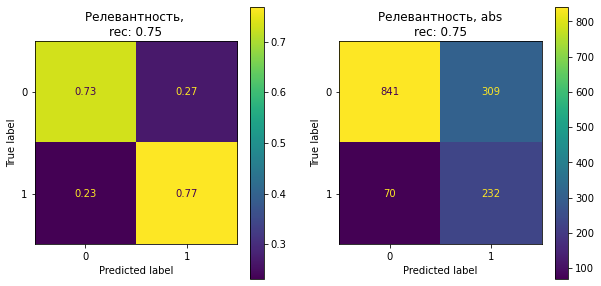

In [54]:
recall_rel = recall_score(y_test['Релевантность'], pred_rel[1], average='macro', zero_division=True)
view_test(y_test['Релевантность'], pred_rel, feats)

In [55]:
recall_ = (recall_rel + recall_takson_relev + recall_takson_not_relev + recall_len + recall_cen) / 5

recall_

0.8981428891575767

# SUBMIT

### submit Таксономия релевантные

In [56]:
%%time
print(clf_takson_relev)
clf_takson_relev_fit_ = fit_func(clf_takson_relev, X_lem, y_lem['Таксономия релевантные'], is_test=False)

LGBMClassifier(random_state=0)
y
1    2479
0    2360
Name: Таксономия релевантные, dtype: int64

After resample
1    2360
0    2360
Name: Таксономия релевантные, dtype: int64
38969
Wall time: 42.5 s


In [57]:
pred_proba_train_takson_relev_ = pred_proba_func(clf_takson_relev_fit_, X_lem, label='Таксономия релевантные')
pred_proba_takson_relev_ = pred_proba_func(clf_takson_relev_fit_, test_lem, label='Таксономия релевантные')

pred_takson_relev_ = pred_func(clf_takson_relev_fit_, test_lem, label='Таксономия релевантные')

### submit Таксономия не релевантные

In [58]:
X_train_stack_takson_rel_ = hstack([X_lem, 
                                    csr_matrix(pred_proba_train_takson_relev_[1].reshape(-1, 1))])

X_test_stack_takson_rel_ = hstack([test_lem, 
                                  csr_matrix(pred_proba_takson_relev_[1].reshape(-1, 1))])

In [59]:
%%time
print(clf_takson_not_relev)
clf_takson_not_relev_fit_ = fit_func(clf_takson_not_relev, 
                                    X_train_stack_takson_rel_, y['Таксономия не релевантные'], is_test=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.7, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=<function custom_recall at 0x0000006E21C21A60>,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)
y
0    4225
1     614
Name: Таксономия не релевантные, dtype: int64

After resample
0    614
1    614
Name: Таксономия не релевантные, dtype: int64
38970
Wall time: 27.3 s


In [60]:
pred_proba_train_takson_not_relev_ = pred_proba_func(clf_takson_not_relev_fit_, 
                                  X_train_stack_takson_rel_, 
                                  label='Таксономия не релевантные')

pred_proba_takson_not_relev_ = pred_proba_func(clf_takson_not_relev_fit_, 
                                  X_test_stack_takson_rel_, 
                                  label='Таксономия не релевантные')


pred_takson_not_relev_ = pred_func(clf_takson_not_relev_fit_, 
                                  X_test_stack_takson_rel_, 
                                  label='Таксономия не релевантные')

### submit Ценности

In [61]:
X_train_stack_takson_not_rel_ = hstack([X_lem, 
                                       csr_matrix(np.round(pred_proba_train_takson_relev_[1]).reshape(-1, 1)),
                                       csr_matrix(np.round(pred_proba_train_takson_not_relev_[1]).reshape(-1, 1))])
X_test_stack_takson_not_rel_ = hstack([test_lem, 
                                      csr_matrix(np.round(pred_proba_takson_relev_[1]).reshape(-1, 1)),
                                      csr_matrix(np.round(pred_proba_takson_not_relev_[1]).reshape(-1, 1))])

In [62]:
%%time
print(clf_cen)
clf_cen_fit_ = fit_func(clf_cen, X_train_stack_takson_not_rel_, y['Ценности'], is_test=False)

LGBMClassifier(random_state=0)
y
1    2623
0    2216
Name: Ценности, dtype: int64

After resample
1    2216
0    2216
Name: Ценности, dtype: int64
38971
Wall time: 36.9 s


In [63]:
pred_proba_train_cen_ = pred_proba_func(clf_cen_fit_, X_train_stack_takson_not_rel_, label='Ценности')
pred_proba_cen_ = pred_proba_func(clf_cen_fit_, X_test_stack_takson_not_rel_, label='Ценности')

pred_cen_ = pred_func(clf_cen_fit_, X_test_stack_takson_not_rel_, label='Ценности')

### submit Длина отзыва

In [64]:
X_train_stack_cen_ = hstack([X, 
                          csr_matrix(np.round(pred_proba_train_takson_relev_[1].reshape(-1, 1))),
                           csr_matrix(np.round(pred_proba_train_takson_not_relev_[1].reshape(-1, 1))),
                           csr_matrix(np.round(pred_proba_train_cen_[1].reshape(-1, 1)))
                           ])
X_test_stack_cen_ = hstack([test, 
                           csr_matrix(pred_takson_relev_[1].reshape(-1, 1)),
                           csr_matrix(pred_takson_not_relev_[1].reshape(-1, 1)),
                           csr_matrix(pred_cen_[1].reshape(-1, 1)),
                            ])

In [65]:
%%time
print(clf_len) 

clf_len_fit_ = fit_func(clf_len, X_train_stack_cen_, y['Длина отзыва'], is_test=False)

LGBMClassifier(random_state=0)
y
0    3703
1    1136
Name: Длина отзыва, dtype: int64

After resample
0    1136
1    1136
Name: Длина отзыва, dtype: int64
41911
Wall time: 20.5 s


In [66]:
pred_proba_train_len_ = pred_proba_func(clf_len_fit_, X_train_stack_cen_, label='Длина отзыва')
pred_proba_len_ = pred_proba_func(clf_len_fit_, X_test_stack_cen_, label='Длина отзыва')

pred_len_ = pred_func(clf_len_fit_, X_test_stack_cen_, label='Длина отзыва')

### submit Релевантность

In [67]:
%%time
print(clf_rel)

clf_rel_fit_ = fit_func(clf_rel, X, y['Релевантность'], is_test=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.3, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=<function custom_recall at 0x0000006E21C21A60>,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)
y
0    3781
1    1058
Name: Релевантность, dtype: int64

After resample
0    1058
1    1058
Name: Релевантность, dtype: int64
41908
Wall time: 26.7 s


In [68]:
pred_rel_ = pred_func(clf_rel_fit_, test, label='Релевантность')

### STACK SUBMIT

In [69]:
pred = np.stack([pred_rel_[1], pred_takson_relev_[1], pred_takson_not_relev_[1], pred_len_[1], pred_cen_[1]]).T

In [70]:
sub = df_test[['RecordNo']].copy()
sub.loc[:, mass_label] = pred.astype(int)

In [71]:
sub

,RecordNo,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,3366,1,0,0,1,1
1,3952,0,1,0,1,0
2,6852,1,0,0,0,1
3,4586,0,0,0,0,1
4,4677,1,1,0,1,0
...,...,...,...,...,...,...
2070,4661,0,1,1,0,1
2071,1547,0,0,1,1,0
2072,6071,1,1,0,1,1
2073,3805,1,1,0,0,1


In [72]:
sub.to_csv('submit.csv', index=False)